In [ ]:
import numpy as np
import pandas as pd
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalMaxPooling1D
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [ ]:
#upload dataset
from google.colab import files
uploaded = files.upload()

Saving Data.csv to Data.csv


**Read data**

In [ ]:
#read dataset
df=pd.read_csv('/content/Data.csv', encoding = "ISO-8859-1", index_col='Date',parse_dates=True)

In [ ]:
df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2016-06-20', '2016-06-21', '2016-06-22', '2016-06-23',
               '2016-06-24', '2016-06-27', '2016-06-28', '2016-06-29',
               '2016-06-30', '2016-07-01'],
              dtype='datetime64[ns]', name='Date', length=4101, freq=None)

In [ ]:
df.head

<bound method NDFrame.head of             Label  ...                                              Top25
Date               ...                                                   
2000-01-03      0  ...                                 Recovering a title
2000-01-04      0  ...                       Millennium bug fails to bite
2000-01-05      0  ...                                       Useful links
2000-01-06      1  ...                        Lessons of law's hard heart
2000-01-07      1  ...                                         Gone aloft
...           ...  ...                                                ...
2016-06-27      0  ...  Pakistani clerics declare transgender marriage...
2016-06-28      1  ...  Mexico's security forces routinely use 'sexual...
2016-06-29      1  ...  Tiny New Zealand town with 'too many jobs' lau...
2016-06-30      1  ...  Law Enforcement Sources: Gun Used in Paris Ter...
2016-07-01      1  ...  Ozone layer hole seems to be healing - US &amp...

[4101 r

In [ ]:
print('Shape =', df.shape)
df.info()

Shape = (4101, 26)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4101 entries, 2000-01-03 to 2016-07-01
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4101 non-null   int64 
 1   Top1    4101 non-null   object
 2   Top2    4101 non-null   object
 3   Top3    4101 non-null   object
 4   Top4    4101 non-null   object
 5   Top5    4101 non-null   object
 6   Top6    4101 non-null   object
 7   Top7    4101 non-null   object
 8   Top8    4101 non-null   object
 9   Top9    4101 non-null   object
 10  Top10   4101 non-null   object
 11  Top11   4101 non-null   object
 12  Top12   4101 non-null   object
 13  Top13   4101 non-null   object
 14  Top14   4101 non-null   object
 15  Top15   4101 non-null   object
 16  Top16   4101 non-null   object
 17  Top17   4101 non-null   object
 18  Top18   4101 non-null   object
 19  Top19   4101 non-null   object
 20  Top20   4101 non-null   object
 21  Top21   4101 non-null  

In [ ]:
df.Label.value_counts()

1    2166
0    1935
Name: Label, dtype: int64

In [ ]:
df

**Clean Data**

In [ ]:
#function to remove punctation marks 
def clean_str(string):
    string = re.sub(r"\\", "", string)  
    string = re.sub(r":", "", string) 
    string = re.sub(r",", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()


In [ ]:
# CONVERT THE TRAINNG DATASET OF 25 COLUMNS INTO ONE ELEMENT IN THE LIST FOR EACH DAY
News_list = []
for row in range(len(df.index)): 
    News_list.append(' '.join(str(k) for k in df.iloc[row,1:25]))

In [ ]:
#cleaning News_list to remove punctuation marks 
texts = []

for idx in range(len(News_list)):
    text = News_list[idx]
    texts.append(clean_str(str(text.encode())))

In [ ]:
# adding another column of clean news in the data 
df['Text_Clean'] = texts 

In [ ]:
# Creatings tokens for every row 
import nltk
nltk.download('punkt')
from nltk import word_tokenize
tokens = [word_tokenize(sen) for sen in df.Text_Clean]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# removing stopwords like 'the', 'a' from tokens list
nltk.download("stopwords") 
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]
filtered_words = [removeStopWords(sen) for sen in tokens]

#adding "text_Final" column after removing stopwords 
df['Text_Final'] = [' '.join(sen) for sen in filtered_words]
df['tokens'] = filtered_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pos = []
neg = []
for l in df.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)
df['Pos']= pos
df['Neg']= neg

data = df[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]
data.head()

,Text_Final,tokens,Label,Pos,Neg
Date,,,,,
2000-01-03,ba hindrance operations extracts leaked report...,"[ba, hindrance, operations, extracts, leaked, ...",0,0,1
2000-01-04,bscorecard best lake scene leader german sleaz...,"[bscorecard, best, lake, scene, leader, german...",0,0,1
2000-01-05,bcoventry caught counter flo uniteds rivals ro...,"[bcoventry, caught, counter, flo, uniteds, riv...",0,0,1
2000-01-06,bpilgrim knows progress thatcher facing ban mc...,"[bpilgrim, knows, progress, thatcher, facing, ...",1,1,0
2000-01-07,bhitches horlocks beckham united survive breas...,"[bhitches, horlocks, beckham, united, survive,...",1,1,0


**Split data into test and train**

In [ ]:
# SPLITTING THE DATASET INTO TRAINING AND TESTING
data_train = data[df.index <= '10-08-11']   
data_test = data[df.index> '10-08-11']

In [ ]:
#making training vocabulary
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

476338 words total, with a vocabulary size of 49178
Max sentence length is 501


In [ ]:
#making testing vocabulary
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

375443 words total, with a vocabulary size of 32130
Max sentence length is 467


**Load Google News Word2Vec model**

In [ ]:
from gensim.models import Word2Vec
word2vec = Word2Vec(data_train['tokens'], min_count=2)

In [ ]:
words = list(word2vec.wv.vocab)
print(words)

['ba', 'operations', 'extracts', 'leaked', 'reports', 'scorecard', 'hughes', 'instant', 'hit', 'blues', 'jack', 'gets', 'skates', 'alex', 'chaos', 'builds', 'united', 'depleted', 'leicester', 'prevail', 'elliott', 'spoils', 'evertons', 'party', 'hungry', 'spurs', 'sense', 'rich', 'pickings', 'gunners', 'wide', 'easy', 'target', 'derby', 'raise', 'glass', 'debut', 'double', 'southgate', 'strikes', 'leeds', 'pay', 'penalty', 'hammers', 'hand', 'robson', 'youthful', 'lesson', 'saints', 'like', '1999', 'wear', 'wolves', 'turned', 'lambs', 'stump', 'mike', 'catches', 'goughs', 'taunt', 'langer', 'escapes', 'flintoff', 'injury', 'piles', 'woe', 'england', 'hunters', 'threaten', 'new', 'battle', 'kohls', 'successor', 'drawn', 'scandal', 'difference', 'men', 'women', 'sara', 'nurse', 'solicitor', 'dianas', 'landmine', 'crusade', 'put', 'tories', 'panic', 'resignation', 'caught', 'opposition', 'russian', 'roulette', 'sold', 'best', 'lake', 'scene', 'leader', 'german', 'sleaze', 'inquiry', 'main

In [ ]:
print(word2vec['word'])

In [ ]:
word2vec.wv.save_word2vec_format('model.bin')

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=100):
    if len(tokens_list)<1:
        return 0
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))
    return list(embeddings)

**Get Embeddings**

In [ ]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [ ]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100

**Tokenize and Pad sequences**

In [ ]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 44858 unique tokens.


In [ ]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(44859, 100)


In [ ]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

**Define CNN**

In [ ]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [ ]:
label_names = ['Pos', 'Neg']

In [ ]:
y_train = data_train[label_names].values
x_train = train_cnn_data
y_tr = y_train
x_test = data_test.iloc[:,1:]
y_test = data_test.iloc[:,2]

In [ ]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 100)      4485900     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 49, 200)      40200       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 48, 200)      60200       embedding_3[0][0]                
____________________________________________________________________________________________

**Train CNN**

In [ ]:
num_epochs = 10
batch_size = 34

In [ ]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, shuffle=False, batch_size=batch_size)

Epoch 1/10
86/86 [==============================] - 5s 53ms/step - loss: 0.7471 - acc: 0.5118
Epoch 2/10
86/86 [==============================] - 4s 51ms/step - loss: 0.6938 - acc: 0.5115
Epoch 3/10
86/86 [==============================] - 5s 52ms/step - loss: 0.6928 - acc: 0.5111
Epoch 4/10
86/86 [==============================] - 5s 53ms/step - loss: 0.6929 - acc: 0.5111
Epoch 5/10
86/86 [==============================] - 4s 52ms/step - loss: 0.6930 - acc: 0.5111
Epoch 6/10
86/86 [==============================] - 4s 52ms/step - loss: 0.6930 - acc: 0.5111
Epoch 7/10
86/86 [==============================] - 5s 53ms/step - loss: 0.6931 - acc: 0.5111
Epoch 8/10
86/86 [==============================] - 4s 52ms/step - loss: 0.6952 - acc: 0.5159
Epoch 9/10
86/86 [==============================] - 4s 51ms/step - loss: 0.6956 - acc: 0.5111
Epoch 10/10
86/86 [==============================] - 4s 52ms/step - loss: 0.6933 - acc: 0.5111


In [ ]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

2/2 [==============================] - 1s 75ms/step


In [ ]:
labels = [1, 0]

**Test CNN**

In [ ]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
print("Accuracy =", sum(data_test.Label==prediction_labels)/len(prediction_labels)*100,'%')

Accuracy = 53.02521008403362 %


In [ ]:
data_test.Label.value_counts()

1    631
0    559
Name: Label, dtype: int64

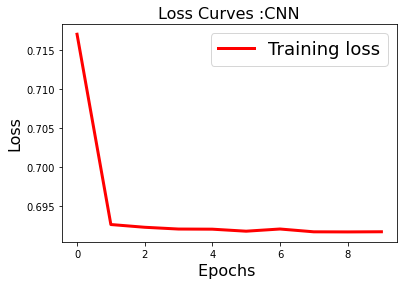

In [ ]:
fig1 = plt.figure()
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.legend(['Training loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()